# Project 2- H5N1 Outbreak Prediction (Classification Model)

### *Research Question:*

#### Did a H5N1 outbreak occur at a specific location and time?

In [680]:
# Initial imports
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
# Needed for decision tree visualization
import pydotplus
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler


# Data Preparation & Cleaning

In [681]:
# Read the datasets

wildbirds = pd.read_csv("../Data/hpai-wild-birds.csv")
wildbirds = wildbirds.rename(columns={'Date Detected': 'Outbreak Date'})
wildbirds_df = wildbirds[wildbirds['HPAI Strain'].str.contains('H5N1', na=False)]
wildbirds_df.head()

,State,County,Collection Date,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency
0,Alabama,Limestone,2/5/2022,2/23/2022,EA H5N1,American wigeon,Wild bird,Hunter harvest,NWDP
1,Alabama,Montgomery,10/29/2022,11/7/2022,EA/AM H5N1,Black vulture,Wild bird,Morbidity/Mortality,NWDP
2,Alabama,Montgomery,10/29/2022,11/7/2022,EA/AM H5N1,Black vulture,Wild bird,Morbidity/Mortality,NWDP
3,Alabama,Montgomery,10/29/2022,11/7/2022,EA/AM H5N1,Black vulture,Wild bird,Morbidity/Mortality,NWDP
4,Alabama,Montgomery,10/29/2022,11/7/2022,EA/AM H5N1,Black vulture,Wild bird,Morbidity/Mortality,NWDP


In [682]:
# Clean the dataset by dropping unimportant columns.

wildbirds_df = wildbirds_df.drop(columns = ['Submitting Agency','Sampling Method','Collection Date'])
#wildbirds_df=wildbirds_df.dropna(subset='Outbreak Date')
wildbirds_df.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification
0,Alabama,Limestone,2/23/2022,EA H5N1,American wigeon,Wild bird
1,Alabama,Montgomery,11/7/2022,EA/AM H5N1,Black vulture,Wild bird
2,Alabama,Montgomery,11/7/2022,EA/AM H5N1,Black vulture,Wild bird
3,Alabama,Montgomery,11/7/2022,EA/AM H5N1,Black vulture,Wild bird
4,Alabama,Montgomery,11/7/2022,EA/AM H5N1,Black vulture,Wild bird


In [683]:
# Function to convert Date to Day, Month and Year

def convert_date(date):
    return pd.Series([date.year, date.month, date.day], index=["year", "month", "day"])


In [684]:
wildbirds_df["Outbreak Date"] = pd.to_datetime(wildbirds_df["Outbreak Date"],errors='coerce')
wildbirds_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9937 entries, 0 to 11624
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                9937 non-null   object        
 1   County               9937 non-null   object        
 2   Outbreak Date        9914 non-null   datetime64[ns]
 3   HPAI Strain          9937 non-null   object        
 4   Bird Species         9937 non-null   object        
 5   WOAH Classification  9937 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 543.4+ KB


In [685]:
# Convert Wild life Outbreak date to Day, Year and Month

wildbirds_df[['Year','Month','Day']]=wildbirds_df['Outbreak Date'].apply(convert_date)
wildbirds_df.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Year,Month,Day
0,Alabama,Limestone,2022-02-23,EA H5N1,American wigeon,Wild bird,2022.0,2.0,23.0
1,Alabama,Montgomery,2022-11-07,EA/AM H5N1,Black vulture,Wild bird,2022.0,11.0,7.0
2,Alabama,Montgomery,2022-11-07,EA/AM H5N1,Black vulture,Wild bird,2022.0,11.0,7.0
3,Alabama,Montgomery,2022-11-07,EA/AM H5N1,Black vulture,Wild bird,2022.0,11.0,7.0
4,Alabama,Montgomery,2022-11-07,EA/AM H5N1,Black vulture,Wild bird,2022.0,11.0,7.0


In [686]:
# Read US counties dataset
us_county_fips=pd.read_csv("../Data/US_Counties.csv")
us_county_fips=us_county_fips.rename(columns={'state_name':'State',"county":"County","county_fips":"FIPS Code","lat":"Latitude","lng":"Longitude"})
us_county_fips=us_county_fips.drop(columns=['state_id','population'])

us_county_fips.head()

,State,County,FIPS Code,Latitude,Longitude
0,Alabama,Autauga,1001,32.5349,-86.6427
1,Alabama,Baldwin,1003,30.7277,-87.7226
2,Alabama,Barbour,1005,31.8696,-85.3932
3,Alabama,Bibb,1007,32.9986,-87.1265
4,Alabama,Blount,1009,33.9809,-86.5674


In [687]:
us_county_fips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      3144 non-null   object 
 1   County     3144 non-null   object 
 2   FIPS Code  3144 non-null   int64  
 3   Latitude   3144 non-null   float64
 4   Longitude  3144 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 122.9+ KB


In [688]:
# Read the weather dataset for adding temperature and Precipitation features

weather_df=pd.read_csv("../Data/weather_cleaned.csv")
weather_df.head()

,State,County,Temp,Precipitation
0,Alabama,Autauga,65.9,52.43
1,Alabama,Baldwin,68.7,60.71
2,Alabama,Barbour,66.4,55.97
3,Alabama,Bibb,64.5,46.88
4,Alabama,Blount,63.1,47.63


In [689]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   State          3107 non-null   object 
 1   County         3107 non-null   object 
 2   Temp           3107 non-null   float64
 3   Precipitation  3107 non-null   float64
dtypes: float64(2), object(2)
memory usage: 97.2+ KB


In [690]:
# Reading the mammals outbreak datasets
mammal_df = pd.read_csv("../Data/HPAI Detections in Mammals.csv")
mammal_df = mammal_df.rename(columns={'Date Detected':'Outbreak Date','Species':'Mammal Species'})
mammal_df = mammal_df[mammal_df['HPAI Strain'].str.contains('H5N1', na=False)]
mammal_df["Outbreak Date"] = pd.to_datetime(mammal_df["Outbreak Date"],errors='coerce')
mammal_df=mammal_df.drop(columns=['Date Collected'])
mammal_df.head()

,State,County,Outbreak Date,HPAI Strain,Mammal Species
0,Oregon,Multnomah,2025-02-10,EA H5N1,Domestic cat
1,Montana,Flathead,2025-02-10,EA AM H5N1,Domestic cat
3,Colorado,Douglas,2025-01-31,EA H5N1,Domestic cat
13,California,Los Angeles,2025-01-15,EA H5N1,Domestic cat
14,California,Los Angeles,2025-01-15,EA H5N1,Domestic cat


In [691]:
# Read mammal df data types
mammal_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 0 to 492
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   State           456 non-null    object        
 1   County          456 non-null    object        
 2   Outbreak Date   456 non-null    datetime64[ns]
 3   HPAI Strain     456 non-null    object        
 4   Mammal Species  456 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 21.4+ KB


In [692]:

# Reading he backyardflock datasets

backyardflock = pd.read_csv("../Data/backyard_flock_old.csv")
backyardflock = backyardflock.rename(columns={'Outbreak Date': 'Outbreak Date'})
backyardflock["Outbreak Date"] = pd.to_datetime(backyardflock["Outbreak Date"],errors='coerce')
#backyardflock=backyardflock.drop(columns=['FullGeoName','FIPS Codes'])
backyardflock.head()

,County,State,Outbreak Date,Flock Type,Flock Size
0,Ottawa,Michigan,2024-12-31,Commercial Turkey Meat Bird,29400
1,Riverside,California,2024-12-31,Commercial Table Egg Layer,181300
2,Spartanburg,South Carolina,2024-12-31,Commercial Upland Gamebird Producer,920
3,Butte,California,2024-12-31,WOAH Non-Poultry,70
4,Miner,South Dakota,2024-12-31,WOAH Poultry,1500


In [693]:
backyardflock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   County         1554 non-null   object        
 1   State          1554 non-null   object        
 2   Outbreak Date  1554 non-null   datetime64[ns]
 3   Flock Type     1554 non-null   object        
 4   Flock Size     1554 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 60.8+ KB


In [694]:
# Combine us county fips df with wild birds

merge_df1=wildbirds_df.merge(us_county_fips,on=['State','County'], how='outer')
#merge_df1=merge_df1.merge(bird_migrate_df,on=['Month','Day','Year'], how='outer')
merge_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11935 entries, 0 to 11934
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                11935 non-null  object        
 1   County               11935 non-null  object        
 2   Outbreak Date        9935 non-null   datetime64[ns]
 3   HPAI Strain          9958 non-null   object        
 4   Bird Species         9958 non-null   object        
 5   WOAH Classification  9958 non-null   object        
 6   Year                 9935 non-null   float64       
 7   Month                9935 non-null   float64       
 8   Day                  9935 non-null   float64       
 9   FIPS Code            11829 non-null  float64       
 10  Latitude             11829 non-null  float64       
 11  Longitude            11829 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(5)
memory usage: 1.1+ MB


In [695]:
merge_df1.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226


In [696]:
# Merge the combined dataframe with backyard flock dataframe
merge_df2=merge_df1.merge(backyardflock,on=['State','County','Outbreak Date'], how='outer')
merge_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471 entries, 0 to 13470
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                13471 non-null  object        
 1   County               13471 non-null  object        
 2   Outbreak Date        11471 non-null  datetime64[ns]
 3   HPAI Strain          9969 non-null   object        
 4   Bird Species         9969 non-null   object        
 5   WOAH Classification  9969 non-null   object        
 6   Year                 9946 non-null   float64       
 7   Month                9946 non-null   float64       
 8   Day                  9946 non-null   float64       
 9   FIPS Code            11840 non-null  float64       
 10  Latitude             11840 non-null  float64       
 11  Longitude            11840 non-null  float64       
 12  Flock Type           1584 non-null   object        
 13  Flock Size           1584 non-n

In [697]:
merge_df2.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN


In [698]:
# Merge mammals data to the merged dataframe
merge_df3=merge_df2.merge(mammal_df,on=['State','County','Outbreak Date'], how='outer')
merge_df3.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN


In [699]:
merge_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14739 entries, 0 to 14738
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                14739 non-null  object        
 1   County               14739 non-null  object        
 2   Outbreak Date        12739 non-null  datetime64[ns]
 3   HPAI Strain_x        10893 non-null  object        
 4   Bird Species         10893 non-null  object        
 5   WOAH Classification  10893 non-null  object        
 6   Year                 10870 non-null  float64       
 7   Month                10870 non-null  float64       
 8   Day                  10870 non-null  float64       
 9   FIPS Code            12764 non-null  float64       
 10  Latitude             12764 non-null  float64       
 11  Longitude            12764 non-null  float64       
 12  Flock Type           1584 non-null   object        
 13  Flock Size           1584 non-n

In [700]:
# Merge weather data to the dataframe
merge_df4=merge_df3.merge(weather_df,on=['State','County'], how='left')
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN


In [701]:
# Fill the missing temperature and precipitation rows with mean values


merge_df4['Temp'] = merge_df4.groupby(['State', 'County'])['Temp'].ffill().bfill()
merge_df4['Precipitation'] = merge_df4.groupby(['State', 'County'])['Precipitation'].ffill().bfill()

    
   
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,58.7,25.03
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03


In [702]:
# Display the merged dataframe types
merge_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14739 entries, 0 to 14738
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                14739 non-null  object        
 1   County               14739 non-null  object        
 2   Outbreak Date        12739 non-null  datetime64[ns]
 3   HPAI Strain_x        10893 non-null  object        
 4   Bird Species         10893 non-null  object        
 5   WOAH Classification  10893 non-null  object        
 6   Year                 10870 non-null  float64       
 7   Month                10870 non-null  float64       
 8   Day                  10870 non-null  float64       
 9   FIPS Code            12764 non-null  float64       
 10  Latitude             12764 non-null  float64       
 11  Longitude            12764 non-null  float64       
 12  Flock Type           1584 non-null   object        
 13  Flock Size           1584 non-n

### Select Target Variable

#### Define a positive case (Outbreak =1)
    If an H5N1 outbreak was recorded at a given state, county and date, label it as 1.
#### Define a Negative case (Outbreak =0)
    For locations and times where no outbreak was recorded, assign 0.

In [703]:
# Create target column for Outbreak data


merge_df4['Outbreak Occurred'] = merge_df4['Outbreak Date'].notna().astype(int)
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Outbreak Occurred
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,58.7,25.03,0
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1


In [704]:
# Check the value counts of target column "Outbreak occured"
merge_df4['Outbreak Occurred'].value_counts()

Outbreak Occurred
1    12739
0     2000
Name: count, dtype: int64

In [705]:
# change the Outbreak date column to year, month and day
merge_df4[['Year','Month','Day']]=merge_df4['Outbreak Date'].apply(convert_date)

merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Outbreak Occurred
0,Alabama,Autauga,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,58.7,25.03,0
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,58.7,25.03,1


In [706]:
merge_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14739 entries, 0 to 14738
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                14739 non-null  object        
 1   County               14739 non-null  object        
 2   Outbreak Date        12739 non-null  datetime64[ns]
 3   HPAI Strain_x        10893 non-null  object        
 4   Bird Species         10893 non-null  object        
 5   WOAH Classification  10893 non-null  object        
 6   Year                 12739 non-null  float64       
 7   Month                12739 non-null  float64       
 8   Day                  12739 non-null  float64       
 9   FIPS Code            12764 non-null  float64       
 10  Latitude             12764 non-null  float64       
 11  Longitude            12764 non-null  float64       
 12  Flock Type           1584 non-null   object        
 13  Flock Size           1584 non-n

# Data Encoding

In [707]:
# Encoding the categorical columns to numerical data
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Fit and transform categorical columns
categorical_cols = ['State', 'County', 'HPAI Strain_x','HPAI Strain_y','Flock Type', 'Bird Species', 'WOAH Classification','Mammal Species']

for col in categorical_cols:
    merge_df4[col] = encoder.fit_transform(merge_df4[col])


merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Outbreak Occurred
0,0,85,NaT,5,219,3,NaN,NaN,NaN,1001.0,32.5349,-86.6427,23,NaN,2,37,58.7,25.03,0
1,0,92,2023-03-01,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,NaN,2,37,58.7,25.03,1
2,0,92,2023-03-01,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,NaN,2,37,58.7,25.03,1
3,0,92,2023-03-01,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,NaN,2,37,58.7,25.03,1
4,0,92,2023-03-01,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,NaN,2,37,58.7,25.03,1


In [708]:
# dipaly the merged dataframe
merge_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14739 entries, 0 to 14738
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                14739 non-null  int32         
 1   County               14739 non-null  int32         
 2   Outbreak Date        12739 non-null  datetime64[ns]
 3   HPAI Strain_x        14739 non-null  int32         
 4   Bird Species         14739 non-null  int32         
 5   WOAH Classification  14739 non-null  int32         
 6   Year                 12739 non-null  float64       
 7   Month                12739 non-null  float64       
 8   Day                  12739 non-null  float64       
 9   FIPS Code            12764 non-null  float64       
 10  Latitude             12764 non-null  float64       
 11  Longitude            12764 non-null  float64       
 12  Flock Type           14739 non-null  int32         
 13  Flock Size           1584 non-n

In [709]:
# Handle missing values

merge_df4=merge_df4.fillna(0) # Replace all NaN with 0
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,Year,Month,Day,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Outbreak Occurred
0,0,85,0,5,219,3,0.0,0.0,0.0,1001.0,32.5349,-86.6427,23,0.0,2,37,58.7,25.03,0
1,0,92,2023-03-01 00:00:00,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,0.0,2,37,58.7,25.03,1
2,0,92,2023-03-01 00:00:00,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,0.0,2,37,58.7,25.03,1
3,0,92,2023-03-01 00:00:00,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,0.0,2,37,58.7,25.03,1
4,0,92,2023-03-01 00:00:00,3,17,2,2023.0,3.0,1.0,1003.0,30.7277,-87.7226,23,0.0,2,37,58.7,25.03,1


In [710]:
# Rename the strains column names

merge_df4=merge_df4.rename(columns={'HPAI Strain_x': 'HPAI Wildbird Strain', 'HPAI Strain_y': 'HPAI Mammal Strain'})
merge_df4.to_csv("../Data/final_dataset.csv")
# Remove the outbreak date column as it is already convered to Year, Month, Day columns
#merge_df4= merge_df4[merge_df4['Month'] != 0]
encoded_df=merge_df4.drop(columns=['Outbreak Date'])

encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14739 entries, 0 to 14738
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   State                 14739 non-null  int32  
 1   County                14739 non-null  int32  
 2   HPAI Wildbird Strain  14739 non-null  int32  
 3   Bird Species          14739 non-null  int32  
 4   WOAH Classification   14739 non-null  int32  
 5   Year                  14739 non-null  float64
 6   Month                 14739 non-null  float64
 7   Day                   14739 non-null  float64
 8   FIPS Code             14739 non-null  float64
 9   Latitude              14739 non-null  float64
 10  Longitude             14739 non-null  float64
 11  Flock Type            14739 non-null  int32  
 12  Flock Size            14739 non-null  float64
 13  HPAI Mammal Strain    14739 non-null  int32  
 14  Mammal Species        14739 non-null  int32  
 15  Temp               

In [711]:
# Correlation map
correlation_df=encoded_df.drop(columns=['State','County','FIPS Code','WOAH Classification','Day','Year'])
correlation_df.corr()

,HPAI Wildbird Strain,Bird Species,Month,Latitude,Longitude,Flock Type,Flock Size,HPAI Mammal Strain,Mammal Species,Temp,Precipitation,Outbreak Occurred
HPAI Wildbird Strain,1.000000,0.584146,-0.363365,-0.477368,0.481995,-0.318581,0.100975,0.054348,0.108165,0.007060,0.021454,-0.519904
Bird Species,0.584146,1.000000,-0.310533,-0.424357,0.413332,-0.301781,0.098541,-0.071045,-0.035003,-0.002815,-0.004395,-0.480912
Month,-0.363365,-0.310533,1.000000,-0.002002,-0.034637,-0.036226,0.007324,0.047637,0.043980,-0.012841,0.000734,0.589829
Latitude,-0.477368,-0.424357,-0.002002,1.000000,-0.893799,0.564861,-0.182648,0.200347,0.147449,-0.098981,-0.124385,-0.076038
Longitude,0.481995,0.413332,-0.034637,-0.893799,1.000000,-0.552402,0.176903,-0.102717,-0.035550,0.029247,0.012611,0.081424
Flock Type,-0.318581,-0.301781,-0.036226,0.564861,-0.552402,1.000000,-0.384420,-0.077131,-0.075837,-0.020044,0.016792,-0.100438
Flock Size,0.100975,0.098541,0.007324,-0.182648,0.176903,-0.384420,1.000000,0.025143,0.024721,0.015570,0.015125,0.032741
HPAI Mammal Strain,0.054348,-0.071045,0.047637,0.200347,-0.102717,-0.077131,0.025143,1.000000,0.891854,-0.018599,0.002728,-0.120565
Mammal Species,0.108165,-0.035003,0.043980,0.147449,-0.035550,-0.075837,0.024721,0.891854,1.000000,-0.041568,-0.024211,-0.118543
Temp,0.007060,-0.002815,-0.012841,-0.098981,0.029247,-0.020044,0.015570,-0.018599,-0.041568,1.000000,0.751653,-0.060728


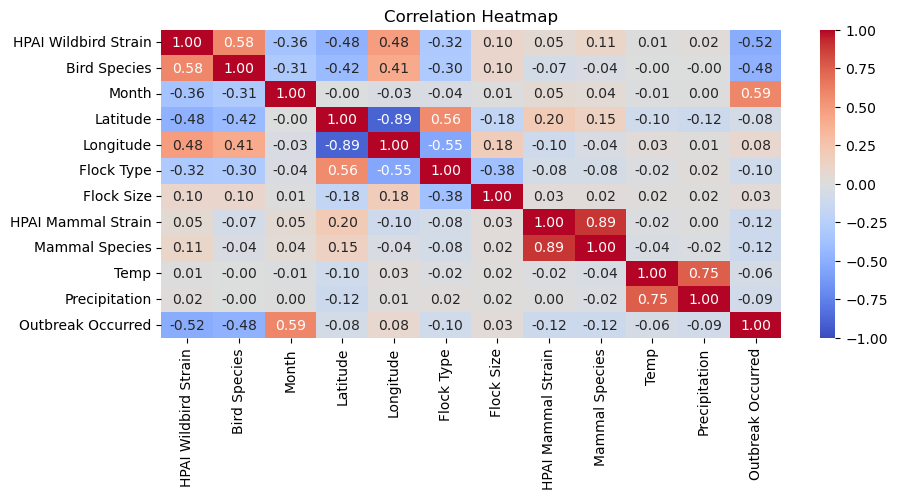

In [712]:
# Plot the correlation

plt.figure(figsize=(10, 4))
sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Key Observations from the Correlation Matrix:

Outbreak Risk has positive correlation with Month (0.59), indicating that the month (likely seasonality) plays a significant role in predicting the outbreaks.

HPAI Mammal Strain and Mammal Species have a high positive correlation (0.891854), which suggests that that specific mammal species are more prone to certain HPAI strains.

Flock Type and Latitude have a moderate positive correlation (0.57), indicating that certain types of flocks might be located at specific latitudes.

The HPAI Strain_x (Wild bird strain) has a moderate positive correlation with the Longitude which means certain bird species are specific to that longitudinal locations. 



Text(0.5, 1.0, 'Distribution of Month')

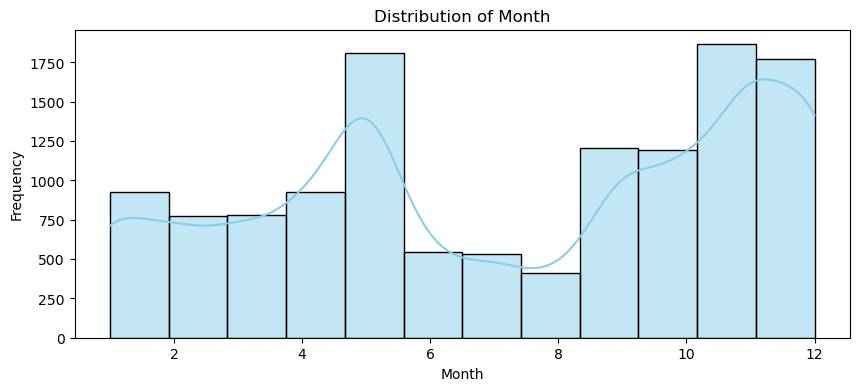

In [713]:
# Plot the month distribution
plt.figure(figsize=(10,4))  
sns.histplot(correlation_df[correlation_df['Month'] != 0]['Month'],bins=12, kde=True,color="skyblue")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.title("Distribution of Month")

# Data Splitting

In [714]:
# Split the training testing data
X=correlation_df.copy().drop(columns='Outbreak Occurred')
y=correlation_df['Outbreak Occurred']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.3)

In [715]:
X_train.shape

(10317, 11)

In [716]:
X_test.shape

(4422, 11)

# Data Scaling

In [717]:
# Use Standard Scaler for scaling the numerical data

scaler=StandardScaler()
X_train_scaled =scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[ 1.3391649 ,  1.24303111, -0.30662968, ...,  0.30088126,
         0.19358162, -0.02600459],
       [-1.08651091, -0.6961513 , -0.30662968, ..., -2.99029035,
         0.19358162, -0.02600459],
       [ 1.3391649 ,  1.24303111, -1.50049277, ...,  0.30088126,
         0.16997392, -0.40062403],
       ...,
       [-1.08651091,  0.78516859, -0.06785706, ...,  0.30088126,
        -0.24906268, -1.01693344],
       [ 0.36889458,  0.00410901,  0.88723341, ...,  0.30088126,
         0.16997392, -0.40062403],
       [ 1.3391649 ,  1.24303111,  1.36477864, ...,  0.30088126,
        -0.24906268, -1.01693344]])

# Model and fit the data to Logistic regression

In [718]:
# Build logistic regression model

from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_scaled, y_train)


LogisticRegression()

In [719]:
# Score the model
print(f"Training Data Score: {logistic_regression_model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {logistic_regression_model.score(X_test_scaled, y_test)}")

Training Data Score: 0.9984491615779781
Testing Data Score: 0.998869289914066


In [720]:
# Make predictions on the test data
predictions = logistic_regression_model.predict(X_test_scaled)

# Create a confusion matrix
print(confusion_matrix(y_test, predictions, labels = [1,0]))

[[3777    0]
 [   5  640]]


In [721]:
# R2 Score

from sklearn.metrics import r2_score

r2_value = r2_score(y_test, predictions)
print("R2 Score :",r2_value)

R2 Score : 0.990924260056277


In [722]:
# Create a classification report
print(classification_report(y_test, predictions, labels = [1, 0]))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3777
           0       1.00      0.99      1.00       645

    accuracy                           1.00      4422
   macro avg       1.00      1.00      1.00      4422
weighted avg       1.00      1.00      1.00      4422



In [723]:
# Calculate the balanced accuracy score
print(balanced_accuracy_score(y_test, predictions))

0.9961240310077519


# Random Forest model

In [724]:
# Train a Random Forest model

from sklearn.ensemble import RandomForestClassifier

rf_model=RandomForestClassifier(random_state=1,n_estimators=500).fit(X_train_scaled,y_train)

In [725]:
# Evaluate the model
print(f'Training Score: {rf_model.score(X_train_scaled, y_train)}')
print(f'Testing Score: {rf_model.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 1.0


In [726]:
# Get the feature importance array
feature_importances = rf_model.feature_importances_

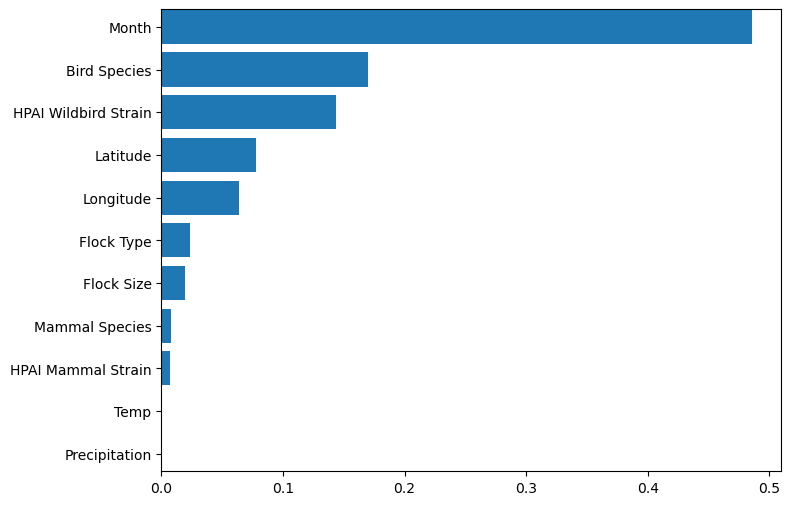

In [727]:
# Plot the feature importances
features = sorted(zip(X.columns, feature_importances), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(8,6)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [728]:
# Make predictions on the test data
predictions1 = rf_model.predict(X_test_scaled)

# Create a confusion matrix
print(confusion_matrix(y_test, predictions1, labels = [1,0]))

[[3777    0]
 [   0  645]]


In [729]:
# Create a classification report
print(classification_report(y_test, predictions1, labels = [1, 0]))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3777
           0       1.00      1.00      1.00       645

    accuracy                           1.00      4422
   macro avg       1.00      1.00      1.00      4422
weighted avg       1.00      1.00      1.00      4422



### Extra Trees Classifier

In [730]:
# Import an Extremely Random Trees classifier
from sklearn.ensemble import ExtraTreesClassifier

In [731]:
# Train the ExtraTreesClassifier model
etc_model = ExtraTreesClassifier(random_state=1).fit(X_train_scaled, y_train)

# Evaluate the model
print(f'Training Score: {etc_model.score(X_train_scaled, y_train)}')
print(f'Testing Score: {etc_model.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.9997738579828132


### Gradient Boosting Classifier

In [732]:
# Import Gradient Boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

In [733]:
gbc_model=GradientBoostingClassifier(random_state=1).fit(X_train_scaled,y_train)

# Evaluate the model
print(f'Training Score: {gbc_model.score(X_train_scaled, y_train)}')
print(f'Testing Score: {gbc_model.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 1.0


## Random Undersampling

In [734]:
# Instantiate the RandomUnderSampler instance
rus = RandomUnderSampler(random_state=1)

# Fit the data to the model
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [735]:
# Check the sample counts
y_resampled.value_counts()

Outbreak Occurred
0    1355
1    1355
Name: count, dtype: int64

In [736]:
# Instantiate an initial RamdonForestClassifier instance
rfc_resample_model = RandomForestClassifier()

# Fit the initial model based the training data
rfc_resample_model.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [737]:
# Make predictions using the model based on the resampled data
y_pred_resampled = rfc_resample_model.predict(X_test)

In [738]:
# Print classification report for resampled data

print(classification_report(y_test, y_pred_resampled, labels = [1, 0]))
#print(classification_report(y_test, predictions1, labels = [1, 0]))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3777
           0       1.00      1.00      1.00       645

    accuracy                           1.00      4422
   macro avg       1.00      1.00      1.00      4422
weighted avg       1.00      1.00      1.00      4422

